# Binary classification of TGCT & TNGCT lesions using Keras api

Last year (September 2021) Feliciani *et al.,* have made a dataset of Testicular Germ and Testicular Non-germ Cell Tumors public. <br>

**The description of the dataset is below: **
<br>
a) Original images: <br>

T1-weighted (T1w) and T2-weighted (T2w MRI images in DICOM format referring to scrotal region of patients affected by testicular neoplasm.
All MR T2 and T1 weighted sequences were acquired with the same 1.5 T Scanner (Achieva Philips, Philips Healthcare, Best, Netherlands) by using a surface coil (Philips Sense Flex Medium coil).
Sequences were acquired with the patients in feet first supine position.
The surface coil was positioned over a towel covering the scrotum after adequate positioning of the penis raised and fixed to the lower abdominal wall.
A peripheral venous access (19-gauge) was obtained in an antecubital fossa vein.

<br>
b) Contouring RadioTheraphy Structure Set:
Manual contouring in DICOM format, performed by expert radiologists analysing the testis and the associated lesion.

<br>
c) Summary of the characteristics of the patients:
Excel Table reporting the demographic, clinical and visual characteristics of the patients.

<br>

MAIN CONTACTS:
- Giacomo Feliciani, IRCCS IRST Meldola, Italy. Email: giacomo.feliciani@irst.emr.it
- Lorenzo Mellini, Department of Morphology Surgery and Experimental Medicine, University of Ferrara, Italy. Email: lore.mellini@gmail.com

<br>
The dataset can be freely downloaded at [this address](https://figshare.com/collections/2021_FelicianiGiacomo_Collection1/5277818/1) and the article can be found [here](https://doi.org/10.6084/m9.figshare.c.5277818.v1)


In this notebook I am trying to build a 3D classifier model that will distinguish between Testicular Germ Cell Tumors and Non-Germ Cell Tumors 

In [5]:
#Loading data from local computer
!unzip -q TNGCT.zip

In [7]:
#Loading data from local computer
!unzip -q TGCT.zip

###Loading Libraries

In [1]:
#importing libraries
import os
import zipfile
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

The files were provided as dicom series and were converted to nifti using the dicom2nifti package of Python. <br>
To read the nifti files, we use the nibabel package. You can install the package via pip install nibabel: 

In [ ]:
!pip install nibabel

##Helper functions to process the data

In [3]:
import nibabel as nib

from scipy import ndimage


def read_nifti_file(filepath):
    """Read and load volume"""
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan


def normalize(volume):
    """Normalize the volume"""
    min = -1000
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume


def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 64
    desired_width = 128
    desired_height = 128
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    img = ndimage.rotate(img, 90, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img


def process_scan(path):
    """Read and resize volume"""
    # Read scan
    volume = read_nifti_file(path)
    # Normalize
    volume = normalize(volume)
    # Resize width, height and depth
    volume = resize_volume(volume)
    return volume

In [8]:
# Folder "TGCT" consist of MRI images from Testicular Germ Cell Tumors
#I made the unfortumate choice to call them "semi"
#Because later on I will be working on a classifier for non-seminomatous & Seminomatous tumors
semi_scan_paths = [
    os.path.join(os.getcwd(), "/content/TGCT", x)
    for x in os.listdir("/content/TGCT")
]
# Folder TNGCT consist of MRI images from Testicular Non-Germ Cell Tumors
nonsemi_scan_paths = [
    os.path.join(os.getcwd(), "/content/TNGCT", x)
    for x in os.listdir("/content/TNGCT")
]

print("images with seminomatous tissue: " + str(len(semi_scan_paths)))
print("images with non-seminomatous tissue: " + str(len(nonsemi_scan_paths)))

images with seminomatous tissue: 64
images with non-seminomatous tissue: 22


## Build train and validation datasets
The code below reads the scans from the class directories and assign labels. <br>
We downsample the scans to have shape of 128x128x64. Rescale the raw HU values to the range 0 to 1. (*Is this correct/useful for MRI data ??*)

Lastly, we split the dataset into train and validation subsets (70-30 split).

In [9]:
# Read and process the scans.
# Each scan is resized across height, width, and depth and rescaled.
nonsemi_scans = np.array([process_scan(path) for path in nonsemi_scan_paths])
semi_scans = np.array([process_scan(path) for path in semi_scan_paths])

# For the non-seminomatous images
# assign 1, for the seminomatous ones assign 0.
nonsemi_labels = np.array([1 for _ in range(len(nonsemi_scans))])
semi_labels = np.array([0 for _ in range(len(semi_scans))])

# Split data for training and validation.
x_train = np.concatenate((nonsemi_scans[:50], semi_scans[:50]), axis=0)
y_train = np.concatenate((nonsemi_labels[:50], semi_labels[:50]), axis=0)
x_val = np.concatenate((nonsemi_scans[50:], semi_scans[50:]), axis=0)
y_val = np.concatenate((nonsemi_labels[50:], semi_labels[50:]), axis=0)
print(
    "Number of samples in train and validation are %d and %d."
    % (x_train.shape[0], x_val.shape[0])
)

Number of samples in train and validation are 72 and 14.


## Data augmentation

The data is augmented by rotating at random angles during training. Since the data is stored in rank-3 tensors of shape (samples, height, width, depth), we add a dimension of size 1 at axis 4 to be able to perform 3D convolutions on the data. The new shape is thus (samples, height, width, depth, 1). <br>

There are different kinds of preprocessing and augmentation techniques (usually for non-medical image dataà, this example comes from the Keras website.

In [10]:
import random
from scipy import ndimage


@tf.function
def rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, -10, -5, 5, 10, 20]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume


def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

While defining the train and validation data loader, the training data is passed through and augmentation function which randomly rotates volume at different angles. Note that both training and validation data are already rescaled to have values between 0 and 1.

##Data Loaders

In [11]:
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

batch_size = 2
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(x_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

Dimension of the scan is: (128, 128, 64, 1)


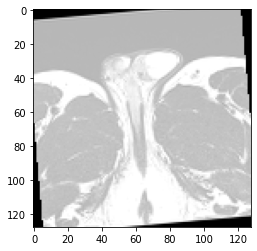

In [12]:
#Vizualize the augmented data(single image)
import matplotlib.pyplot as plt

data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print("Dimension of the scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 30]), cmap="gray")

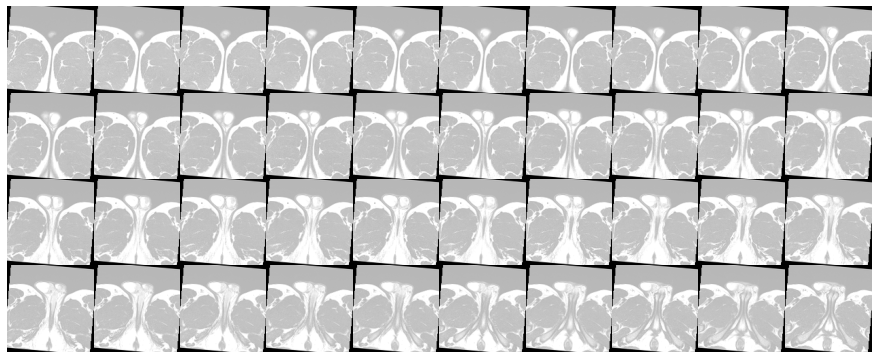

In [13]:
#Vizualize the augmented data(multiple images)
def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 20 slices"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()


# Visualize montage of slices.
# 4 rows and 10 columns for 100 slices of the CT scan.
plot_slices(4, 10, 128, 128, image[:, :, :40])

## Define 3D Convolutional Network
The architecture below is based on [this paper](https://arxiv.org/abs/2007.13224)

In [14]:
def get_model(width=128, height=128, depth=64):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model(width=128, height=128, depth=64)
model.summary()

Model: "3dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 64, 1)  0         
                             ]                                   
                                                                 
 conv3d (Conv3D)             (None, 126, 126, 62, 64)  1792      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 63, 63, 31, 64)   0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 63, 63, 31, 64)   256       
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 61, 61, 29, 64)    110656    
                                                             

###Train Model

In [15]:
# Compile model.
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 100
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/100
36/36 - 21s - loss: 0.7747 - acc: 0.5417 - val_loss: 0.6060 - val_acc: 1.0000 - 21s/epoch - 575ms/step
Epoch 2/100
36/36 - 13s - loss: 0.6887 - acc: 0.7083 - val_loss: 0.4790 - val_acc: 1.0000 - 13s/epoch - 352ms/step
Epoch 3/100
36/36 - 11s - loss: 0.6526 - acc: 0.6944 - val_loss: 0.4035 - val_acc: 1.0000 - 11s/epoch - 307ms/step
Epoch 4/100
36/36 - 11s - loss: 0.7400 - acc: 0.6111 - val_loss: 0.5569 - val_acc: 1.0000 - 11s/epoch - 303ms/step
Epoch 5/100
36/36 - 12s - loss: 0.6785 - acc: 0.6667 - val_loss: 0.5924 - val_acc: 1.0000 - 12s/epoch - 336ms/step
Epoch 6/100
36/36 - 11s - loss: 0.5975 - acc: 0.6389 - val_loss: 0.6786 - val_acc: 0.9286 - 11s/epoch - 302ms/step
Epoch 7/100
36/36 - 11s - loss: 0.7080 - acc: 0.6667 - val_loss: 0.4537 - val_acc: 1.0000 - 11s/epoch - 304ms/step
Epoch 8/100
36/36 - 11s - loss: 0.6324 - acc: 0.6389 - val_loss: 0.6451 - val_acc: 0.6429 - 11s/epoch - 304ms/step
Epoch 9/100
36/36 - 11s - loss: 0.7341 - acc: 0.5972 - val_loss: 0.5018 - val_ac

##Visualizing model performance
Here the model accuracy and loss for the training and the validation sets are plotted. <br>
If the validation set is class-balanced, accuracy provides an unbiased representation of the model's performance.

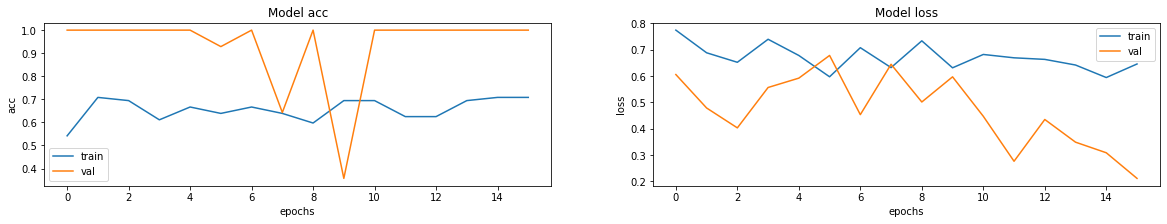

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

##Predictions

In [17]:
# Load best weights.
model.load_weights("3d_image_classification.h5")
prediction = model.predict(np.expand_dims(x_val[0], axis=0))[0]
scores = [1 - prediction[0], prediction[0]]

class_names = ["seminomatous", "non-seminomatous"]
for score, name in zip(scores, class_names):
    print(
        "This model is %.2f percent confident that a scan is %s"
        % ((100 * score), name)
    )

This model is 86.29 percent confident that a scan is seminomatous
This model is 13.71 percent confident that a scan is non-seminomatous
